<a href="https://colab.research.google.com/github/shizoda/education/blob/main/image/dcgan_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np

# ハイパーパラメータ
params = {
    "n_epochs": 300,      # エポック数 (CIFAR-10はFashionMNISTより複雑なので多めに設定)
    "batch_size": 128,    # バッチサイズ
    "lr": 0.0002,         # 学習率
    "beta1": 0.5,         # Adamオプティマイザのパラメータ
    "nz": 100,            # 潜在変数の次元数 (ノイズのサイズ)
    "ngf": 128,            # Generatorの特徴マップのサイズ
    "ndf": 64,            # Discriminatorの特徴マップのサイズ
    "image_size": 32,     # CIFAR-10の画像サイズは32x32
    "nc": 3,              # 画像のチャンネル数 (CIFAR-10はカラーなので3)
    "target_class_name": "automobile" # 学習したいクラス名
}

# GPUが利用可能か確認し、デバイスを設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


CIFAR-10 class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Targeting class: 'automobile' (index: 1)
Number of images for 'automobile': 5000


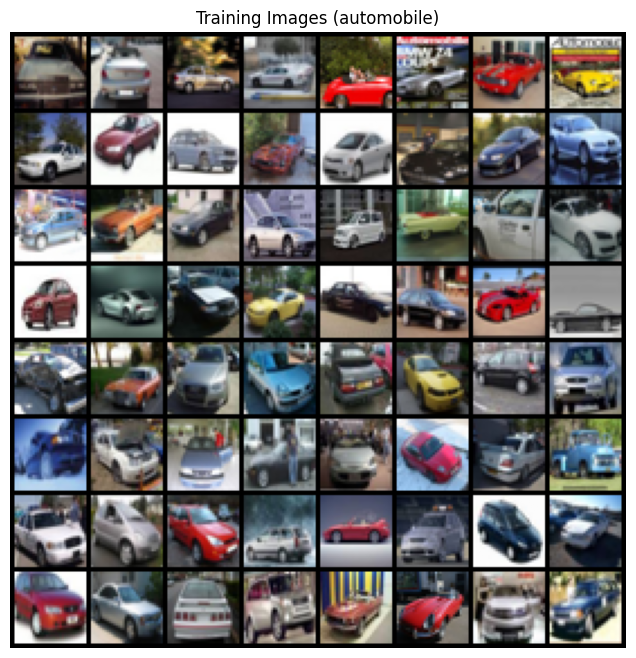

In [2]:
# 画像の前処理
transform = transforms.Compose([
    transforms.Resize(params["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # [-1, 1]に正規化
])

# データセットのダウンロード
full_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# CIFAR-10のクラス名
class_names = full_dataset.classes
print(f"CIFAR-10 class names: {class_names}")

# 学習対象のクラスのインデックスを取得
try:
    target_class_idx = class_names.index(params["target_class_name"])
    print(f"Targeting class: '{params['target_class_name']}' (index: {target_class_idx})")
except ValueError:
    print(f"Error: '{params['target_class_name']}' is not a valid CIFAR-10 class name. Please choose from {class_names}")
    exit()

# 特定のクラスのデータのみを抽出
indices = [i for i, label in enumerate(full_dataset.targets) if label == target_class_idx]
dataset = Subset(full_dataset, indices)
dataloader = DataLoader(dataset, batch_size=params["batch_size"], shuffle=True)

if len(dataset) == 0:
    print(f"Error: No images found for class '{params['target_class_name']}'. Please check the class name or dataset.")
    exit()
else:
    print(f"Number of images for '{params['target_class_name']}': {len(dataset)}")

# データの可視化 (確認用)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Training Images ({params['target_class_name']})")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [3]:
# 重みの初期化関数
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 入力は潜在変数Z
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False), # CIFAR-10は画像サイズが小さいのでConvTransposeの層を調整
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh() # 出力は-1から1の範囲
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [4]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ndf, nc):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # 確率を出力
        )

    def forward(self, input):
        return self.main(input)

In [5]:
# モデルのインスタンス化
netG = Generator(params["nz"], params["ngf"], params["nc"]).to(device)
netD = Discriminator(params["ndf"], params["nc"]).to(device)

# 重みの初期化を適用
netG.apply(weights_init)
netD.apply(weights_init)

# 損失関数とオプティマイザ
criterion = nn.BCELoss() # バイナリクロスエントロピー損失

# 学習の進捗可視化用に、固定のノイズを生成
fixed_noise = torch.randn(64, params["nz"], 1, 1, device=device)

# 本物と偽物のラベル
real_label = 0.9
fake_label = 0.1

# オプティマイザの設定
optimizerD = optim.Adam(netD.parameters(), lr=params["lr"], betas=(params["beta1"], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params["lr"], betas=(params["beta1"], 0.999))

# 学習ループ
G_losses = []
D_losses = []
img_list = []
iters = 0

print(f"Starting Training Loop for class: {params['target_class_name']}...")
for epoch in range(params["n_epochs"]):
    for i, data in enumerate(dataloader, 0):
        # ---------------------
        # (1) Discriminatorの学習
        # ---------------------
        netD.zero_grad()
        # 本物の画像で学習
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 偽物の画像で学習
        noise = torch.randn(b_size, params["nz"], 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # 損失を合計し、オプティマイザで更新
        errD = errD_real + errD_fake
        optimizerD.step()

        # ---------------------
        # (2) Generatorの学習
        # ---------------------
        netG.zero_grad()
        label.fill_(real_label) # Generatorにとっては偽物が本物
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 損失を記録
        if i % 50 == 0: # 50イテレーションごとにログを出力
            print(f'[{epoch+1}/{params["n_epochs"]}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # 各エポックの終わりに、固定ノイズから生成した画像を確認
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(make_grid(fake, padding=2, normalize=True))

print("Training Finished.")

Starting Training Loop for class: automobile...
[1/300][0/40] Loss_D: 1.8447 Loss_G: 1.3788 D(x): 0.2750 D(G(z)): 0.3260 / 0.2552
[2/300][0/40] Loss_D: 0.8571 Loss_G: 3.6973 D(x): 0.6949 D(G(z)): 0.1536 / 0.0192
[3/300][0/40] Loss_D: 0.8642 Loss_G: 4.8725 D(x): 0.8079 D(G(z)): 0.2935 / 0.0052
[4/300][0/40] Loss_D: 1.0672 Loss_G: 1.3763 D(x): 0.5995 D(G(z)): 0.1465 / 0.2365
[5/300][0/40] Loss_D: 1.2702 Loss_G: 2.3968 D(x): 0.7617 D(G(z)): 0.5241 / 0.0872
[6/300][0/40] Loss_D: 0.9957 Loss_G: 2.0633 D(x): 0.6265 D(G(z)): 0.2334 / 0.1168
[7/300][0/40] Loss_D: 1.5480 Loss_G: 2.8802 D(x): 0.3911 D(G(z)): 0.1023 / 0.0905
[8/300][0/40] Loss_D: 1.2622 Loss_G: 1.8670 D(x): 0.5310 D(G(z)): 0.2866 / 0.1650
[9/300][0/40] Loss_D: 1.2476 Loss_G: 1.5754 D(x): 0.5363 D(G(z)): 0.3275 / 0.2042
[10/300][0/40] Loss_D: 1.0330 Loss_G: 2.1410 D(x): 0.7105 D(G(z)): 0.3001 / 0.1052
[11/300][0/40] Loss_D: 1.3941 Loss_G: 3.0270 D(x): 0.6895 D(G(z)): 0.5155 / 0.0524
[12/300][0/40] Loss_D: 1.1835 Loss_G: 2.1857 D(x

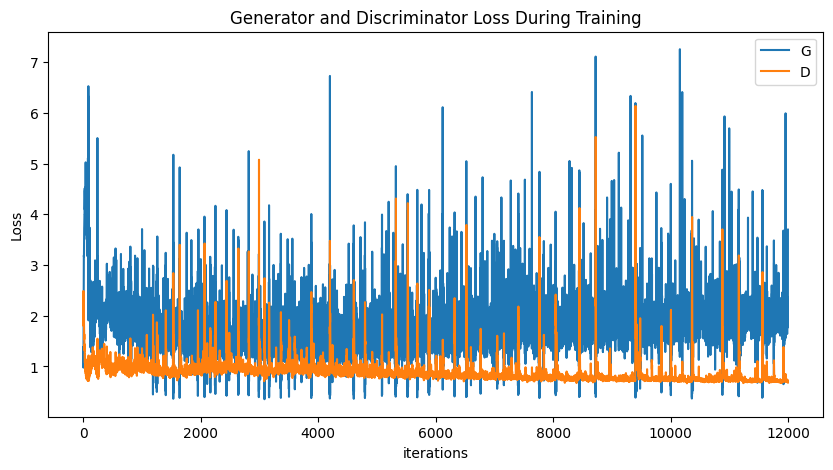

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

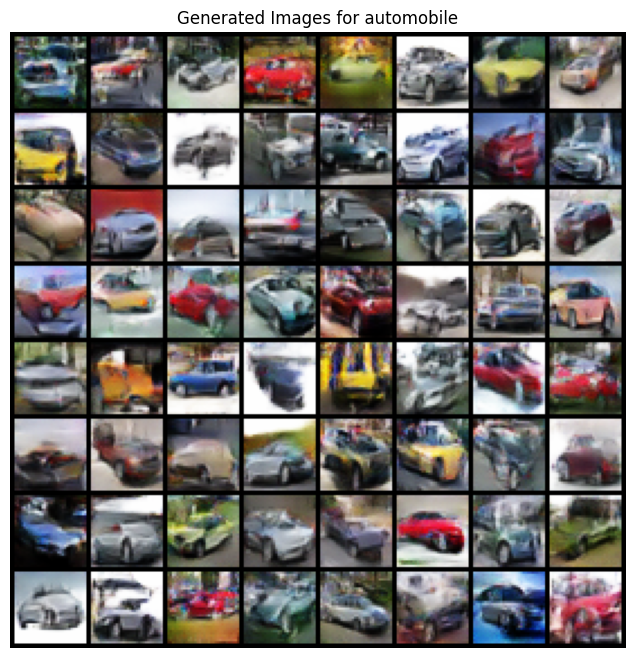

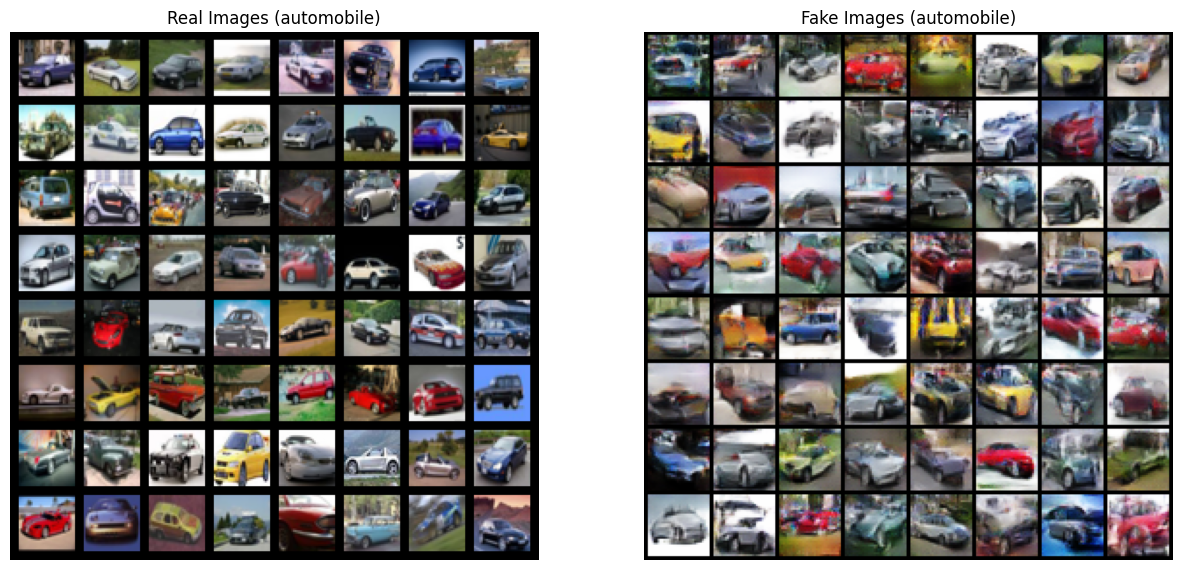

In [7]:
# 最後の_エポックで生成された画像を表示
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title(f"Generated Images for {params['target_class_name']}")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

if len(dataloader) > 0:
    real_batch = next(iter(dataloader))

    # --- 変更箇所 ---

    # 1行2列のサブプロットを作成 (figsizeを (15,15) から (16,8) のような横長に調整)
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # 1. 順序を逆にする (Fake Images を左に [0])
    axes[0].imshow(np.transpose(img_list[-1], (1, 2, 0)))
    axes[0].set_title(f"Fake Images ({params['target_class_name']})")

    # 2. 順序を逆にする (Real Images を右に [1])
    # make_gridの処理を変数に格納
    real_images_grid = make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu()
    axes[1].imshow(np.transpose(real_images_grid, (1, 2, 0)))
    axes[1].set_title(f"Real Images ({params['target_class_name']})")

    # 2. 両方の枠線を調整 (両方の軸を非表示にする)
    axes[0].axis('off')
    axes[1].axis('off')

    # サブプロット間の余白を調整
    plt.tight_layout()

    plt.show()
    # --- 変更ここまで ---

else:
    print(f"Cannot display real images as the dataloader for {params['target_class_name']} is empty.")